# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### Load data and create binary masks 

In [4]:
%%time
# io
fname = "/media/scholz_la/hd3/20200221_NZ0036/*.tiff"
parameterfile = "/home/scholz_la/Desktop/pumping/PharaGlow/pharaglow_parameters_mks.txt"
outfile = "/media/scholz_la/hd3/NZ0036_analyzed/20200221_NZ0036_{}_{}.json"
lawnfile ='/media/scholz_la/hd2/Nicolina/Nicolina/Lawns/NZ0036_lawn.tiff'

print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[:]

print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)
    

Starting pharaglow analysis...
Loading parameters from ['PharaGlow', 'pharaglow_parameters_mks.txt']
open and binarize lawn file
CPU times: user 9.03 s, sys: 734 ms, total: 9.76 s
Wall time: 1.36 s


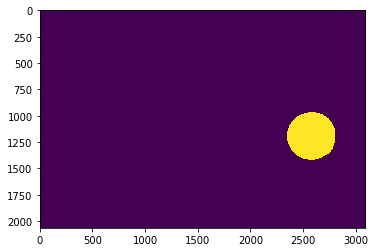

In [40]:
from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
image = gaussian(lawn, 5, preserve_range = True)
thresh = threshold_li(image)
binary = image > thresh*0.8
binary = remove_small_holes(binary, area_threshold=15000, connectivity=1, in_place=False)
binary = remove_small_objects(binary, min_size=50000, connectivity=8, in_place=False)
binLawn = binary
plt.imshow(binLawn)

In [41]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate =3 , tfactor=0.9)


Binarizing images
CPU times: user 2min 4s, sys: 8.58 s, total: 2min 12s
Wall time: 23.1 s


### Make sure the thesholding worked otherwise change parameters

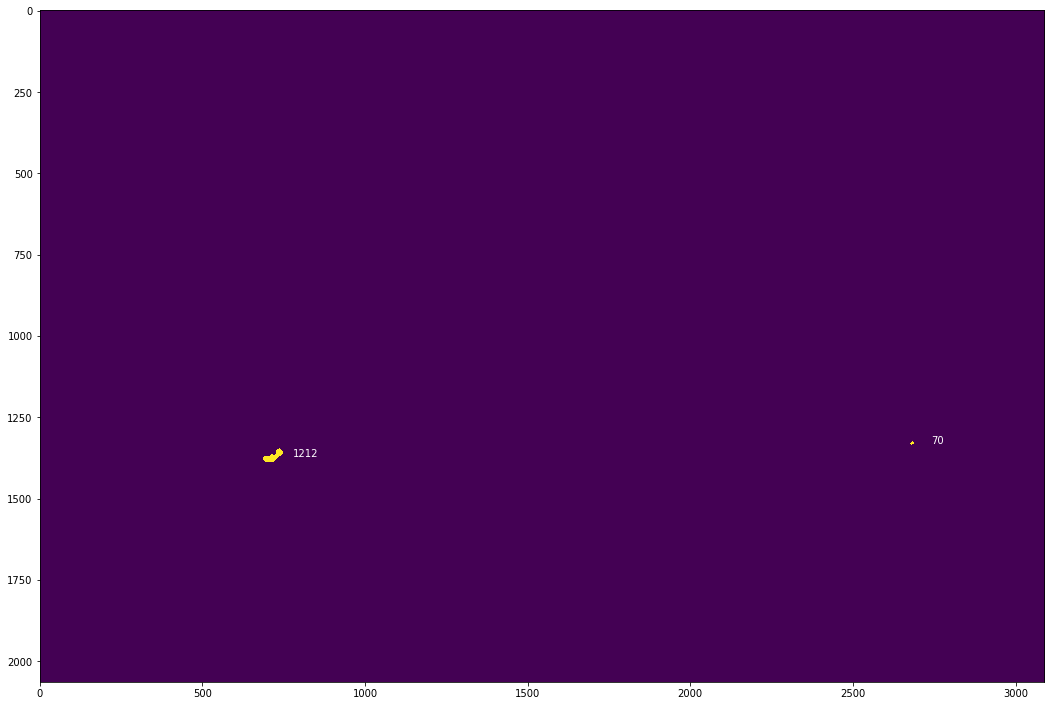

In [48]:
from skimage.measure import label, regionprops
t = 500
plt.figure(figsize=(18,16))
# plt.subplot(121)
plt.imshow(rawframes[t])#+lawn)
# plt.subplot(122)
plt.imshow(masks[t])#[1400:1600,300:600])#[500:1500,2000:3500])#[:,2500:])
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+60, region.centroid[0], region.area, color ='w')

# Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [49]:
%%time
import time

nWorkers = 10
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        if len(rawframes[a:b])>1:
            return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

Detecting features
9001
Expected time is approx. 1719.1877281239297 s
CPU times: user 6.35 s, sys: 7.09 s, total: 13.4 s
Wall time: 30min 49s


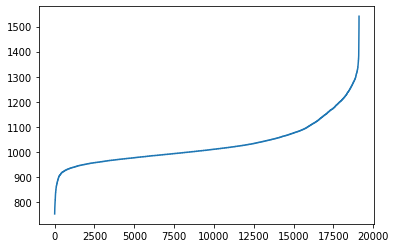

In [50]:

### Save the features
plt.plot(np.sort(features['area'].values))

In [51]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 0
Data columns (total 9 columns):
area     19113 non-null int64
diffI    19113 non-null object
frame    19113 non-null int64
image    19113 non-null object
slice    19113 non-null object
x        19113 non-null float64
xw       19113 non-null float64
y        19113 non-null float64
yw       19113 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 5.7 MB


In [5]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [6]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 10, memory= 30)

Frame 8998: 2 trajectories present.


In [7]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj)

Interpolating trajectories


In [54]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,600)
print(trajectories['particle'].nunique())

19
7


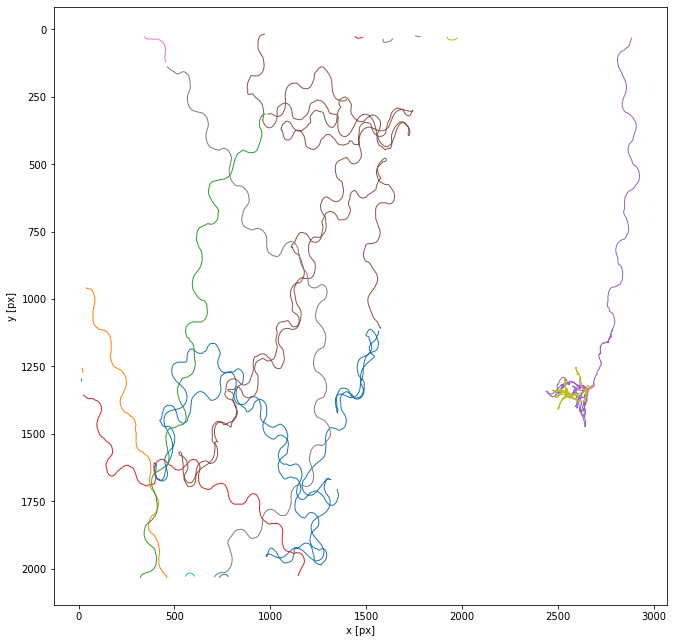

In [9]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories)#, superimpose=1-masks[8000]);

### Save / Load trajectories if you need to have a checkpoint

In [ ]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

In [ ]:
trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
trajectories['image'].replace('None', np.nan, inplace=True)

In [ ]:
trajectories['image'].replace([None], np.nan, inplace=True)

### add the missing images to interpolated trajectories

In [58]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                               length=param['length'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else row['image'], axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                length=param['length'], size=param['watershed'])) if np.all(np.isnan(row['diffI'])) else row['diffI'], axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                length=param['length'], size=param['watershed'])) if np.sum((row['diffI']))==0 else row['diffI'], axis=1)

Fill in missing images
CPU times: user 23.8 s, sys: 4.15 s, total: 27.9 s
Wall time: 55.9 s


### Extract lawn info

In [59]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 2.68 s


### Show resulting trajectories

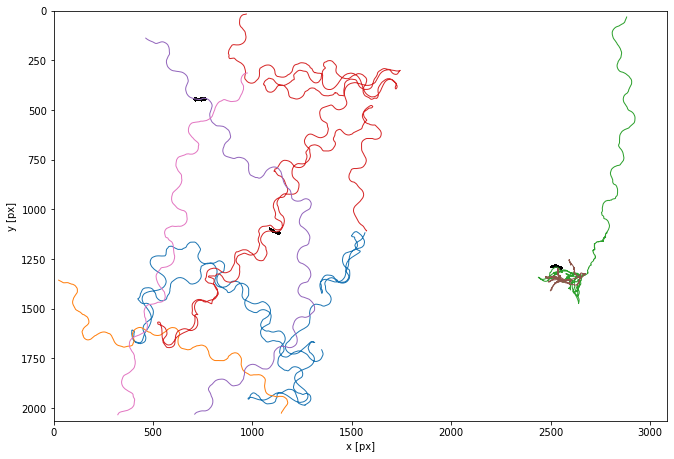

In [60]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[4100]);

In [62]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in [4]:#trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')

### check slow-down before continuing analysis

4.0


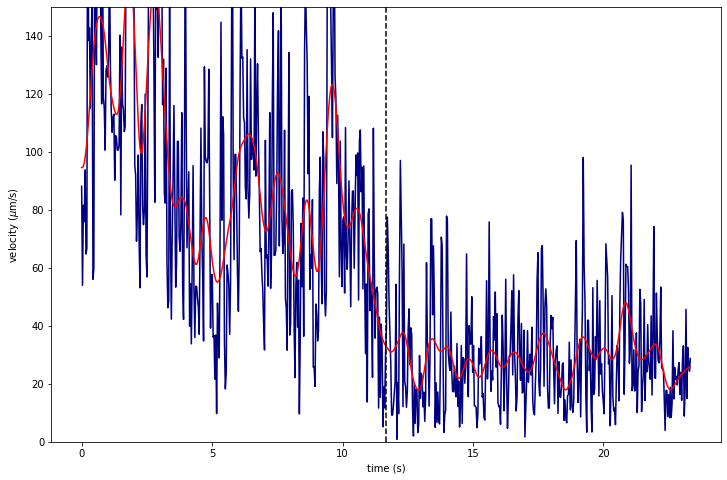

In [66]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 350
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            if t0>dt:
                print(pid)
                time = np.linspace(0,2*dt/30., 2*dt)
                v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                plt.plot(time, v.iloc[t0-dt:t0+dt].values, 'navy', alpha=0.1)
                
                vcut.append(v.iloc[t0-dt:t0+dt].values)
    plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
    plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
    plt.axvline(dt/30, color='k', linestyle='--')
    plt.ylabel(r"velocity ($\mu$m/s)");
    plt.xlabel("time (s)");
    plt.ylim(0,150)


### run the whole pharaglow feature extraction

In [63]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [64]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)
def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], param['length']*param['length'])) if len(row['image'])<param['length']*param['length'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], param['length']*param['length'])) if len(row['diffI'])<param['length']*param['length'] else row['diffI'], axis=1)
    

### Save data as hdf5 format (every trajectory in a file)

In [65]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        print('Analyzing trajectory:', fn)
        # interpolate if images are not the right size:
        fixImages(traj)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 5, params = param)
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        

Analyzing trajectory: 20200221_NZ0036_trajectories_4.json
[883, 883, 883, 882, 882]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameter

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 98 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 99 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 91 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silen

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 85 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 97 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 88 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 84 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimag

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 75 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 114 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 112 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/sk

CPU times: user 35.3 s, sys: 12.7 s, total: 48 s
Wall time: 33min 56s
